In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
import importlib
import functions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

importlib.reload(functions)

pd.set_option('display.max_columns', None)

In [27]:
df = pd.read_csv('data/dataset_meal.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Water_Intake (liters),BMI,meal_type,diet_type,cooking_method,cluster_id,Cal,meal_name,C,P,M,ED,F
0,35,Male,65.27,1.62,1.50,24.87,Lunch,Vegan,Grilled,2,602.000000,Grilled Vegan Lunch,0.405052,0.342572,0.697313,0.258372,0.173291
1,23,Female,56.41,1.55,1.90,23.48,Lunch,Vegetarian,Fried,2,525.666667,Fried Vegetarian Lunch,0.607290,0.211067,0.696730,0.247696,0.471934
2,33,Female,58.98,1.67,1.88,21.15,Breakfast,Paleo,Boiled,1,804.000000,Boiled Paleo Breakfast,0.579913,0.604530,0.697190,0.082439,0.096575


In [28]:
user = pd.read_csv('data/new_user.csv')
user.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,22,Female,56.0,1.7,19.377163,1,2,2,Low-Carb,Loss,5.0,31,1,1351.5,1.55,2094.825,38500.0,19250.0,19250.0,1473.857258,8.857143,2173.387097


In [29]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.35*df['C'] + 0.25*df['P'] + 0.15*df['M'] + 0.15*df['ED'] + 0.1*df['F']
elif goal == 'Maintain':
    df['target'] = 0.3*df['C'] + 0.25*df['M'] + 0.2*df['P'] + 0.1*df['ED'] + 0.15*df['F']
elif goal == 'Gain':
    df['target'] = 0.4*df['C'] + 0.3*df['P'] + 0.15*df['M'] + 0.1*df['ED'] + 0.05*df['F']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

### Training dataset preparation

In [30]:
df = df.drop(columns=['C', 'P', 'M', 'ED', 'F'])
df.head(3)
df_full = df.copy()

In [31]:
# 3) Split X/y
X = df.drop(columns=['target'])
y = df['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [32]:
numerical_features = ['Age', 'Weight (kg)', 'Height (m)', 'Water_Intake (liters)', 'BMI']

categorical_features = ['Gender', 'meal_type', 'diet_type', 'cooking_method', 'cluster_id', 'meal_name']

In [33]:
# 4) One-hot encoding (fit on train only, transform val/test)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

### Baseline model: Linear Regression

In [34]:
lr = LinearRegression()
lr.fit(X_train_enc, y_train)
val_pred_lr = lr.predict(X_val_enc)

rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))

print(f"Validation RMSE (Linear Regression): {rmse_lr:.7f}")

Validation RMSE (Linear Regression): 0.0670849


### Main model: XGBoost

In [35]:
# --------------------------------------------------
# Manual selection of n_estimators using VALIDATION
# --------------------------------------------------

n_estimators_list = [50, 100, 200, 300, 500]
results = []

for n in n_estimators_list:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    
    model.fit(X_train_enc, y_train)
    val_pred = model.predict(X_val_enc)
    
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    results.append((n, rmse))

# --------------------------------------------------
# Select best n_estimators
# --------------------------------------------------

best_n, best_rmse = min(results, key=lambda x: x[1])
print(f"Best n_estimators: {best_n}")
print(f"Validation RMSE: {best_rmse:.4f}")

# --------------------------------------------------
# Train FINAL model on training data
# --------------------------------------------------

final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(X_train_enc, y_train);  


Best n_estimators: 500
Validation RMSE: 0.0439


In [36]:
test_pred = final_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0449


### Hyperparameter tuning

In [37]:
# Base model (we keep objective fixed for regression)
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Parameter search space (covers the big knobs)
param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

# Use neg MSE for max compatibility with older sklearn,
# then we take sqrt later for RMSE.
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                 # increase to 80+ if you can afford time
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_enc, y_train)

print("Best CV params:", search.best_params_)
print("Best CV RMSE:", np.sqrt(-search.best_score_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV params: {'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.0001, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV RMSE: 0.037644144527335735


In [38]:
best_model = search.best_estimator_

val_pred = best_model.predict(X_val_enc)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"Validation RMSE after tuning: {val_rmse:.6f}")

Validation RMSE after tuning: 0.035947


In [39]:
test_pred = best_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.6f}")

Test RMSE: 0.036642


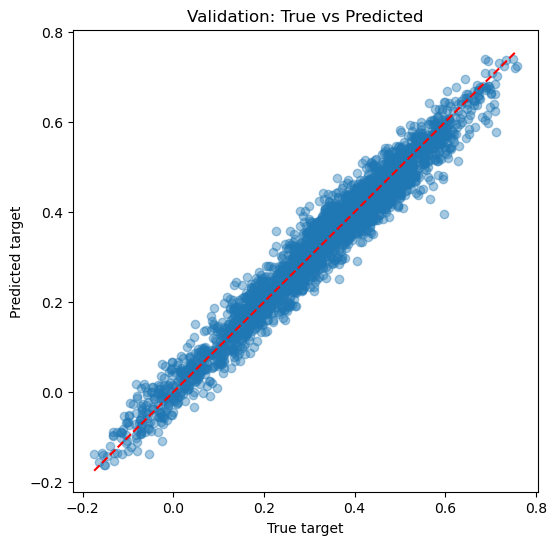

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.4)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Validation: True vs Predicted")
plt.show()


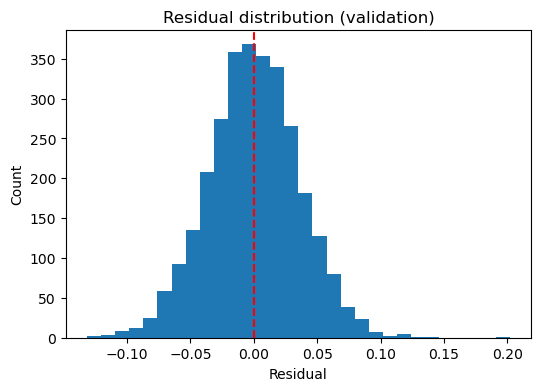

In [41]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution (validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


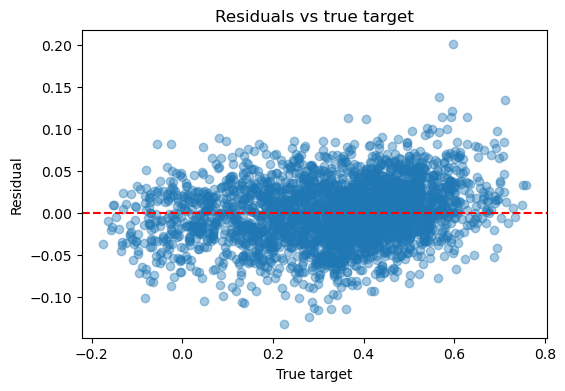

In [42]:
plt.figure(figsize=(6,4))
plt.scatter(y_val, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target")
plt.ylabel("Residual")
plt.title("Residuals vs true target")
plt.show()

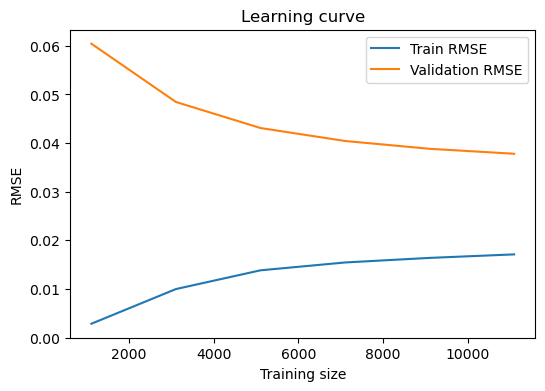

In [43]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve")
plt.legend()
plt.show()


#### Save the model and encoder

In [44]:
import joblib

joblib.dump(preprocess, "encoders/meal_encoder.pkl")
joblib.dump(final_model, "models/meal_model.pkl")
print("Saved the meal model!")

Saved the meal model!


In [45]:
user_full = user.copy()
user = user.drop(
                    columns=['Goal', 'WeightChange (kg)', 'GoalDays', 'BMR', 'PAL', 'TDEE', 'CalorieChange', 'CaloriesToBurnTraining', 
                        'CaloriesReducedFromFood', 'CaloriesPerDay',  'TotalWorkouts', 'CaloriesPerWorkout', 'Experience_Level', 
                        'Workout_Frequency (days)', 'Daily meals frequency']
                )

In [46]:
user

,Age,Gender,Weight (kg),Height (m),BMI,diet_type,cluster_id
0,22,Female,56.0,1.7,19.377163,Low-Carb,1


In [47]:
# Meal-related features
meal_df = df[
                    ['Water_Intake (liters)', 'meal_type', 'cooking_method', 'meal_name' ]
].reset_index(drop=True)

# Repeat user row to match number of meals 
meal_predict = pd.concat(
    [pd.concat([user] * len(meal_df), ignore_index=True), meal_df],
    axis=1
)

meal_predict.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,diet_type,cluster_id,Water_Intake (liters),meal_type,cooking_method,meal_name
0,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.50,Lunch,Grilled,Grilled Vegan Lunch
1,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.90,Lunch,Fried,Fried Vegetarian Lunch
2,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.88,Breakfast,Boiled,Boiled Paleo Breakfast


In [48]:
preprocess = joblib.load("encoders/meal_encoder.pkl")
final_model = joblib.load("models/meal_model.pkl")

meal_predict_enc = preprocess.transform(meal_predict)
predictions = final_model.predict(meal_predict_enc)

In [49]:
# Add predictions as a new column
meal_predict = meal_predict.copy()
meal_predict["meal_score"] = predictions

meal_predict["Calories"] = df_full["Cal"].values

meal_predict.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,diet_type,cluster_id,Water_Intake (liters),meal_type,cooking_method,meal_name,meal_score,Calories
0,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.50,Lunch,Grilled,Grilled Vegan Lunch,0.486011,602.000000
1,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.90,Lunch,Fried,Fried Vegetarian Lunch,0.470626,525.666667
2,22,Female,56.0,1.7,19.377163,Low-Carb,1,1.88,Breakfast,Boiled,Boiled Paleo Breakfast,0.472136,804.000000


In [ ]:
ALLOWED_PORTIONS = [0.5, 1.0, 1.5, 2.0]

def adjust_portions_per_meal(
    df: pd.DataFrame,
    target_calories: float
) -> pd.DataFrame:

    df = df.copy()
    df["Portion"] = 1.0
    df["Calories_Final"] = df["Calories"]
    df = df.sort_values("Calories", ascending=False).reset_index(drop=True)

    current_total = df["Calories_Final"].sum()

    while current_total < target_calories:

        changed = False

        for i in range(len(df)):
            current_portion = df.loc[i, "Portion"]
            if current_portion < 2.0:
                new_portion = current_portion + 0.5

                if new_portion in ALLOWED_PORTIONS:
                    delta = df.loc[i, "Calories"] * 0.5
                    df.loc[i, "Portion"] = new_portion
                    df.loc[i, "Calories_Final"] += delta

                    current_total += delta
                    changed = True

                    if current_total >= target_calories:
                        break
        if not changed:
            break

    return df





# ----------------------------
# 1) Candidate generation: Top N meals
# ----------------------------
TOP_N = 100
candidates = (
    meal_predict
    [meal_predict["diet_type"] == user['diet_type'].iloc[0]]
    .sort_values("meal_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)

# ----------------------------
# 2) Build text for vectorization (optional, e.g., for meal type / diet_type)
# ----------------------------
TEXT_COLS = ["meal_name", "diet_type", "cooking_method"]  # можно расширять

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

meal_text = make_text_profile(candidates)

# TF-IDF vectors for meals
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_meal = vectorizer.fit_transform(meal_text)

# ----------------------------
# 3) Create "day prototypes" (breakfast/lunch/dinner/snack or day parts)
# ----------------------------
day_prototypes = {
    "Breakfast": "breakfast",
    "Lunch": "lunch",
    "Dinner": "dinner",
    "Snack": "snack",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)

# similarity of each meal to each day prototype
S_day = cosine_similarity(X_meal, X_proto)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)

# ----------------------------
# 4) MMR reranking: relevant + diverse + calories target per meal
# ----------------------------
def mmr_select_calories(df_day: pd.DataFrame, X_day_vecs, calories_target, k=4, alpha=0.75):
    if len(df_day) == 0:
        return df_day

    rel = df_day["meal_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))
    sims = cosine_similarity(X_day_vecs, X_day_vecs)
    current_calories = 0.0

    while remaining and len(selected_idx) < k and current_calories < calories_target:
        if not selected_idx:
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx]) if selected_idx else 0
                mmr = alpha * rel[i] - (1 - alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        current_calories += df_day.iloc[best]["Calories"]
        remaining.remove(best)
        if current_calories >= calories_target:
            break

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Generate meal plan for all days
# ----------------------------
target_food = float(user_full["CaloriesPerDay"].iloc[0] * user_full["GoalDays"].iloc[0])
goal_days = int(user_full['GoalDays'].iloc[0])
target_per_meal = float(user_full['CaloriesPerDay'].iloc[0] / user_full['Daily meals frequency'].iloc[0])
meals_per_day = int(user_full["Daily meals frequency"].iloc[0])

plan = []
remaining_calories = target_food

candidates_sorted = candidates.sort_values("meal_score", ascending=False).copy()
X_candidates = X_meal[candidates_sorted.index]

selected_idx = []
current_calories = 0.0
alpha = 0.75  
sims = cosine_similarity(X_candidates, X_candidates)
rel = candidates_sorted["meal_score"].to_numpy()
rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

while current_calories < remaining_calories and len(selected_idx) < len(candidates_sorted):
    if not selected_idx:
        best = int(np.argmax(rel))
    else:
        mmr_scores = []
        for i in range(len(candidates_sorted)):
            if i in selected_idx:
                mmr_scores.append(-np.inf)
                continue
            max_sim_to_selected = np.max(sims[i, selected_idx]) if selected_idx else 0
            mmr = alpha * rel[i] - (1 - alpha) * max_sim_to_selected
            mmr_scores.append(mmr)
        best = int(np.argmax(mmr_scores))
    
    selected_idx.append(best)
    current_calories += candidates_sorted.iloc[best]["Calories"]

final_plan = candidates_sorted.iloc[selected_idx].copy()
final_plan["Portion"] = 1.0 

day_names = ["Breakfast", "Lunch", "Dinner", "Snack"]

rows = []
idx = 0

for day in range(1, goal_days + 1):
    day_meals = final_plan.iloc[idx:idx + meals_per_day].copy()

    if len(day_meals) < meals_per_day:
        extra = final_plan.iloc[:meals_per_day - len(day_meals)]
        day_meals = pd.concat([day_meals, extra])

    day_meals["Day"] = day
    day_meals["day_label"] = day_names[:meals_per_day]

    rows.append(day_meals)
    idx += meals_per_day

meal_plan_df = pd.concat(rows, ignore_index=True)
meal_plan_df = adjust_portions_per_meal(
    meal_plan_df,
    target_calories=target_food
)

meal_plan_df = meal_plan_df.sort_values("Day").reset_index(drop=True)
print(f"Target total calories: {target_food:.2f}")
print(f"Actual total calories: {meal_plan_df['Calories_Final'].sum():.2f}")
print(f"Difference: {meal_plan_df['Calories_Final'].sum() - target_food:.2f}")
display(meal_plan_df[["meal_name", "diet_type", "Calories_Final", "day_label", "Day", "Portion"]])


Target total calories: 45689.57
Actual total calories: 58775.50
Difference: 13085.93


,meal_name,diet_type,Calories_Final,day_label,Day,Portion
0,Roasted Keto Lunch,Low-Carb,929.333333,Lunch,1,1.0
1,Steamed Keto Breakfast,Low-Carb,1041.000000,Breakfast,1,1.0
2,Roasted Keto Lunch,Low-Carb,901.333333,Lunch,2,1.0
3,Steamed Low-Carb Lunch,Low-Carb,629.333333,Breakfast,2,1.0
4,Roasted Keto Lunch,Low-Carb,960.333333,Breakfast,3,1.0
...,...,...,...,...,...,...
57,Steamed Keto Breakfast,Low-Carb,1041.000000,Breakfast,29,1.0
58,Roasted Keto Lunch,Low-Carb,929.333333,Lunch,30,1.0
59,Steamed Keto Breakfast,Low-Carb,1041.000000,Breakfast,30,1.0
60,Steamed Keto Breakfast,Low-Carb,1041.000000,Breakfast,31,1.0


Exception ignored in: <function ResourceTracker.__del__ at 0x102fe5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106e89bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1050f1bc0>
Traceback (most recent call last